Instructions and Summary of the Model

1st Step: Install necessary packages as instructed in the initial cells, then import the required libraries.

2nd Step: Update the file paths to match the project folder and the cropped folder within it, which we provided. This step ensures that the images are cropped to remove zero-value pixels before being fed into the model.

3rd Step: Change the paths again, this time to the cropped and 128x128 folders. The model will resize the images to 128x128 pixels and compress them accordingly.

4th Step: Update the path once more, replacing the 128x128 folder path with your designated folder path. The following processes will then take place:

-The code will extract the images to prepare them for the deep learning model.

-Images will be converted to grayscale, as SSPOR operates exclusively with grayscale images.

-The dataset will be split, allocating 80% for training and 20% for testing.

-SSPOR will determine the optimal sensor positions for the chosen number of modes (you can adjust the number of sensors and modes). A visual representation of the selected sensors will be displayed.

-The dataset will be transformed for CNN input. The original colored images will be converted into images with selectively colored sensors in 3 channels (RGB). An example of this transformed CNN input dataset will be shown.

-The CNN architecture will be constructed, and the model will be trained. A graph illustrating the Mean Squared Error (MSE) per epoch will be displayed.

-Finally, a comparison between the CNN input, the CNN output, and the expected result will be presented.

The model has been run with varying numbers of modes and sensors to study the influence of these parameters on the flow field reconstruction.

In [ ]:
pip install python-sensors

In [ ]:
pip install opencv-python

In [ ]:
pip install tensorflow

In [4]:
from time import time
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn import datasets
import pysensors as ps
from sklearn import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
import zipfile
import os
import cv2
from PIL import Image

In [ ]:
# Specify the directory containing the images
image_directory = 'C:\\Users\\Patricia\\Downloads\\Project\\Project'
cropped_directory = 'C:\\Users\\Patricia\\Downloads\\Project\\Project\\cropped'



# Specify the cropping coordinates (left, upper, right, lower)
#crop_box = (left, top, right, bottom)
crop_box = (182, 149, 1138, 1106)


# Iterate over each file in the directory
for filename in os.listdir(image_directory):
    if filename.endswith('.tiff'):  # Filter image files
        # Open the image using Pillow
        img = Image.open(os.path.join(image_directory, filename))

        # Crop the image using the specified coordinates
        cropped_img = img.crop(crop_box)

        # Save the cropped image with a new filename
        cropped_filename = 'cropped_' + filename
        cropped_img.save(os.path.join(cropped_directory, cropped_filename))

        print(f'Cropped {filename} and saved as {cropped_filename}')


In [6]:
# Set the input and output directories
input_dir = 'C:\\Users\\Patricia\\Downloads\\Project\\Project\\cropped'
output_dir = 'C:\\Users\\Patricia\\Downloads\\Project\\Project\\128x128'

# Set the target size
target_size = (128, 128)

#Compress image to 128x128
# Loop through the files in the input directory
for filename in os.listdir(input_dir):
    # Check if the file is an image
    if filename.endswith('.tiff'):
        # Open the image
        image_path = os.path.join(input_dir, filename)
        image = Image.open(image_path)

        # Resize the image
        image = image.resize(target_size, resample=Image.BICUBIC)

        # Save the compressed image to the output directory
        output_path = os.path.join(output_dir, filename)
        image.save(output_path)
        print(f'Compressed {filename} to {target_size}')

Compressed cropped_1.tiff to (128, 128)
Compressed cropped_10.tiff to (128, 128)
Compressed cropped_100.tiff to (128, 128)
Compressed cropped_11.tiff to (128, 128)
Compressed cropped_12.tiff to (128, 128)
Compressed cropped_13.tiff to (128, 128)
Compressed cropped_14.tiff to (128, 128)
Compressed cropped_15.tiff to (128, 128)
Compressed cropped_16.tiff to (128, 128)
Compressed cropped_17.tiff to (128, 128)
Compressed cropped_18.tiff to (128, 128)
Compressed cropped_19.tiff to (128, 128)
Compressed cropped_2.tiff to (128, 128)
Compressed cropped_20.tiff to (128, 128)
Compressed cropped_21.tiff to (128, 128)
Compressed cropped_22.tiff to (128, 128)
Compressed cropped_23.tiff to (128, 128)
Compressed cropped_24.tiff to (128, 128)
Compressed cropped_25.tiff to (128, 128)
Compressed cropped_26.tiff to (128, 128)
Compressed cropped_27.tiff to (128, 128)
Compressed cropped_28.tiff to (128, 128)
Compressed cropped_29.tiff to (128, 128)
Compressed cropped_3.tiff to (128, 128)
Compressed cropped

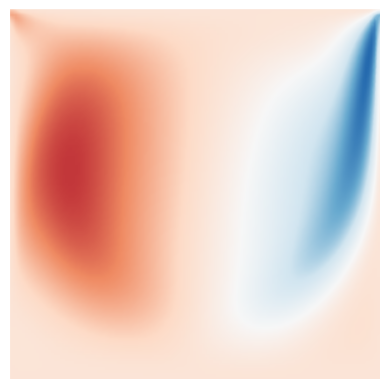

In [7]:
#Plot an image example
cropped_filename="cropped_89.tiff" #change number to try other image
# Load and display the image
img = mpimg.imread(os.path.join(cropped_directory, cropped_filename))  # Read the image
plt.imshow(img)  # Display the image
plt.axis('off')  # Optionally, turn off the axis lines and labels
plt.show()  # Show the image

In [8]:
#Check dataset shape (number of samples, width, height, channels of colours )
# Path to your dataset
extract_path = 'C:\\Users\\Patricia\\Downloads\\Project\\Project\\128x128'

# List the extracted files
extracted_files = os.listdir(extract_path)

# Load images into a list
images = [mpimg.imread(os.path.join(extract_path, fname)) for fname in extracted_files]

# Convert the list of images to a NumPy array
X = np.array(images)
del images

# Get the shape of the array
print('Array shape:', X.shape)
#Expected (100, 128, 128, 3)

Array shape: (100, 128, 128, 3)


In [9]:
# Assuming your NumPy array is named 'image_array'
# Create an empty list to store the grayscale images
grayscale_images = []

# Iterate over each image in the array
for i in range(X.shape[0]):
    # Convert the NumPy array to a PIL Image
    pil_image = Image.fromarray(X[i])

    # Convert the PIL Image to grayscale
    grayscale_image = pil_image.convert('L')

    # Append the grayscale image to the list
    grayscale_images.append(np.array(grayscale_image))

# Convert the list of grayscale images to a NumPy array
grayscale_array = np.array(grayscale_images)

grayscale_array.shape
#Expected (100, 128, 128)

(100, 128, 128)

In [10]:
#Convert dataset into gray scale to feed SSPOR (1 channel of colour)
# Original shape
original_shape = (100, 128, 128)

# Flatten height * width
n_features = 128 * 128

# Correctly reshape to (100, n_features)
X_reshaped = grayscale_array.reshape(100, n_features)
del grayscale_array

# Confirm new shape
print("New reshaped array shape:", X_reshaped.shape)
#Expected (100, 16384)

New reshaped array shape: (100, 16384)


In [11]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test = train_test_split(X_reshaped, test_size=0.2, random_state=42)
del X_reshaped

# Check the sizes of the training and testing sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

image_shape = (128, 128, 1)

Training set shape: (80, 16384)
Testing set shape: (20, 16384)


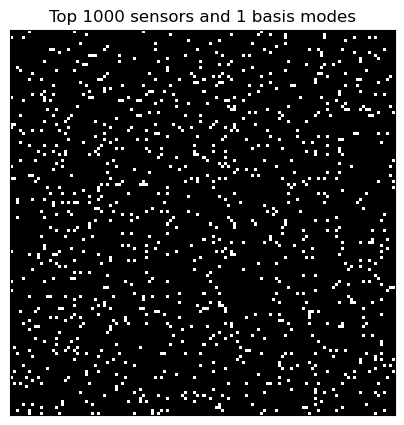

In [12]:
#SSPOR Model to get sensor positions
n_sensors = 1000 #change this
n_basis_modes=1 #change this
model = ps.SSPOR(n_sensors=n_sensors,basis=ps.basis.SVD(n_basis_modes=n_basis_modes)) #Identity/RandomProjection
model.fit(X_train)

selected_sensors = model.get_selected_sensors() #(n_sensors,)Indices of the sensors chosen by the model(i.e. the sensor locations) ranked in descending order of importance.
all_sensors = model.get_all_sensors() #(n_features,)Indices of sensors in descending order of importance.

#Show locations of "n best sensors"
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

#trocar sensores para branco
img = np.full(n_features, 255, dtype=np.uint8)
img[selected_sensors] = 0

#Plot, sensors chosed
ax.imshow(img.reshape(image_shape), cmap=plt.cm.binary)
ax.set(title=f'Top {n_sensors} sensors and {n_basis_modes} basis modes', xticks=[], yticks=[]);

In [13]:
#Dataset Transformation (with 3 channels of colours)
def construct_cnn_input(old_dataset, sensor_positions):
    new_X = np.full((100, 128, 128, 3), 0, dtype=np.uint8)
    new_Y = np.full((100, 128, 128, 3), 0, dtype=np.uint8)

    X_reshaped = old_dataset.reshape(100, 128*128, 3)

    for id, image in enumerate(X_reshaped):
        sensor_values = np.full((128*128, 3), 0, dtype=np.uint8)
        for sensor in sensor_positions:
            sensor_values[sensor][0] = image[sensor][0]
            sensor_values[sensor][1] = image[sensor][1]
            sensor_values[sensor][2] = image[sensor][2]

        new_X[id] = sensor_values.reshape(128,128,3)
        new_Y[id] = image.reshape(128,128,3)

    return new_X, new_Y

new_X, new_Y = construct_cnn_input(X, selected_sensors)

In [14]:
#Dataset split to 80% for training and 20% for validatio of the CNN
print(type(X))
print(type(new_X))
X_train, X_test, y_train, y_test = train_test_split(new_X, new_Y, train_size=0.8, random_state=42)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


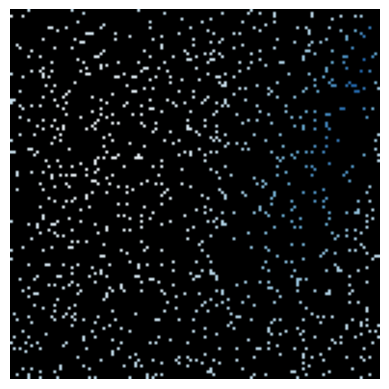

In [15]:
#Check dataset images for CNN input
plt.imshow(X_train[10])  # Display the image, change this
plt.axis('off')  # Optionally, turn off the axis lines and labels
plt.show()  # Show the image

X_train : <class 'numpy.ndarray'>
X_train shape: (80, 128, 128, 3)


C:\Users\Patricia\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 756ms/step - accuracy: 0.4119 - loss: 37220.9375 - val_accuracy: 0.5517 - val_loss: 2724.1372
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 701ms/step - accuracy: 0.4746 - loss: 3830.6860 - val_accuracy: 0.0263 - val_loss: 2730.7231
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 646ms/step - accuracy: 0.3480 - loss: 2644.4133 - val_accuracy: 0.0315 - val_loss: 2250.9739
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 637ms/step - accuracy: 0.2418 - loss: 2164.6628 - val_accuracy: 0.5877 - val_loss: 1877.2574
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 638ms/step - accuracy: 0.4496 - loss: 1719.4814 - val_accuracy: 0.0290 - val_loss: 1519.2734
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 639ms/step - accuracy: 0.2492 - loss: 1476.1443 - val_accuracy: 0.5517 - val_loss: 1274.2916
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 640ms/step - accuracy: 0.4450 - loss: 1147.5669 - val_accuracy: 0.5507 - val_loss: 1104.5066
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 645ms/step - accurac

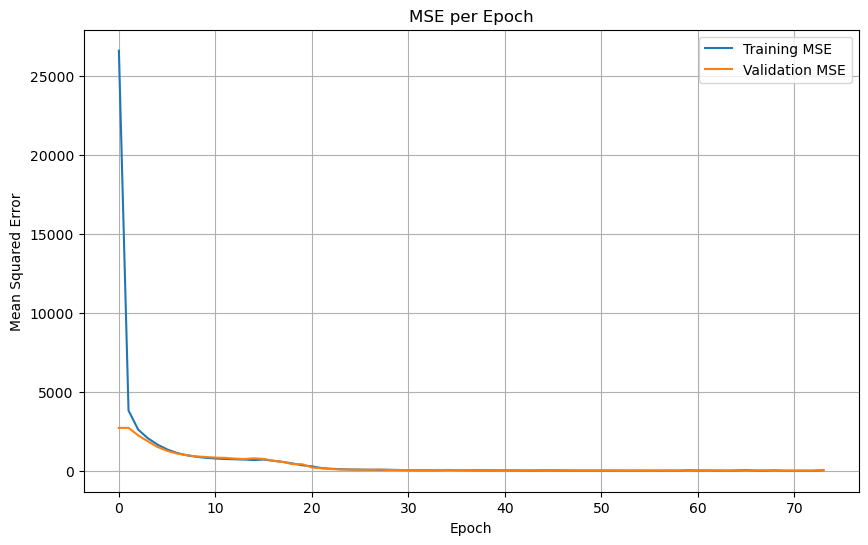

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,001,867 (3.82 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 667,912 (2.55 MB)

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def cnn_model(input_dim, X_train, y_train, X_test, y_test):
    model = Sequential()

    # Encoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_dim))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Decoder
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

    # Output
    model.add(Conv2D(3, (3, 3), activation='linear', padding='same'))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    # Define Early Stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=1000, batch_size=12, validation_data=(X_test, y_test), callbacks=[early_stopping])
    
    best_val_acc = max(history.history['val_accuracy'])
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    
    # Plot the MSE per epoch
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training MSE')
    plt.plot(history.history['val_loss'], label='Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.title('MSE per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model

print("X_train :", type(X_train))
print("X_train shape:", X_train.shape)

input_dim = (128, 128, 3)
model = cnn_model(input_dim, X_train, y_train, X_test, y_test)
model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


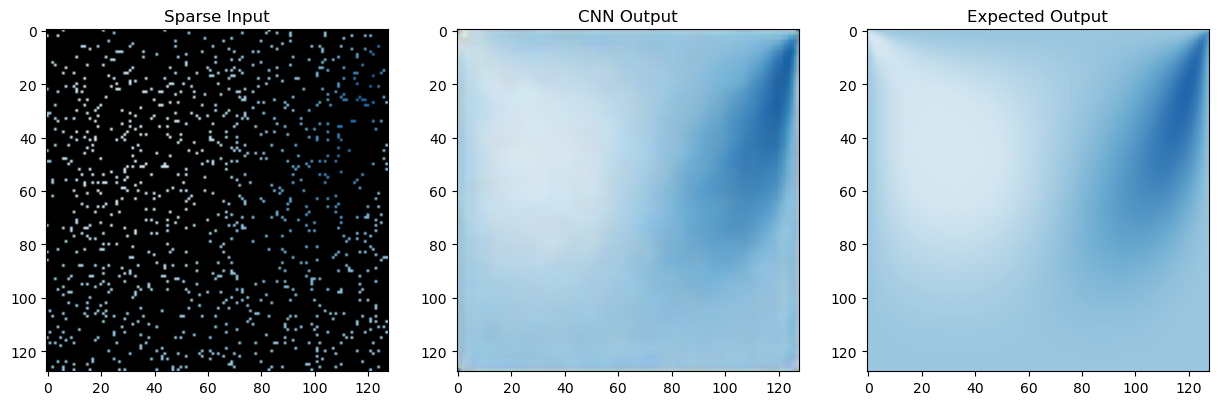

In [17]:
# Visualize the results
def visualize_results(sparse_input, cnn_output, expected_output):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Plot the sparse input
    axes[0].imshow(sparse_input)
    axes[0].set_title('Sparse Input')

    # Plot the CNN output
    axes[1].imshow(cnn_output)
    axes[1].set_title('CNN Output')

    # Plot the expected output
    axes[2].imshow(expected_output)
    axes[2].set_title('Expected Output')

    plt.show()

# Example usage
selected=15

sparse_input = X_test[selected]

cnn_input=np.zeros((1,128,128,3), dtype=np.uint8)
cnn_input[0]=X_test[selected]

cnn_output = model.predict(cnn_input)
cnn_output = cnn_output.astype(np.uint8)
cnn_output = cnn_output.reshape(128,128,3)

expected_output = y_test[selected]
visualize_results(sparse_input, cnn_output, expected_output)

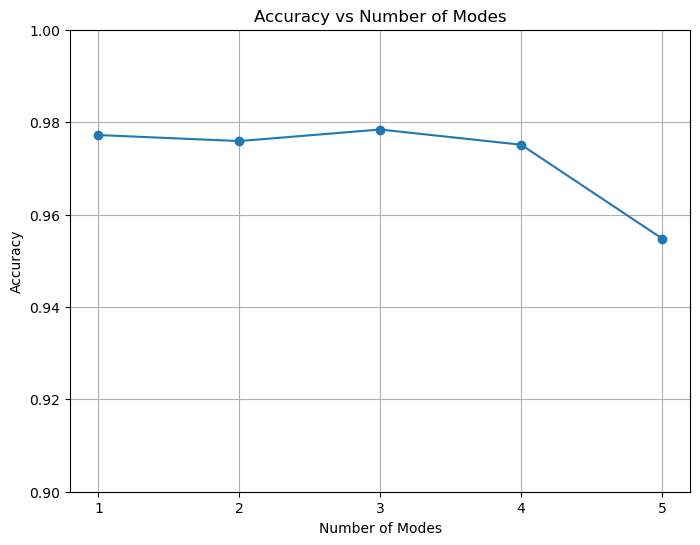

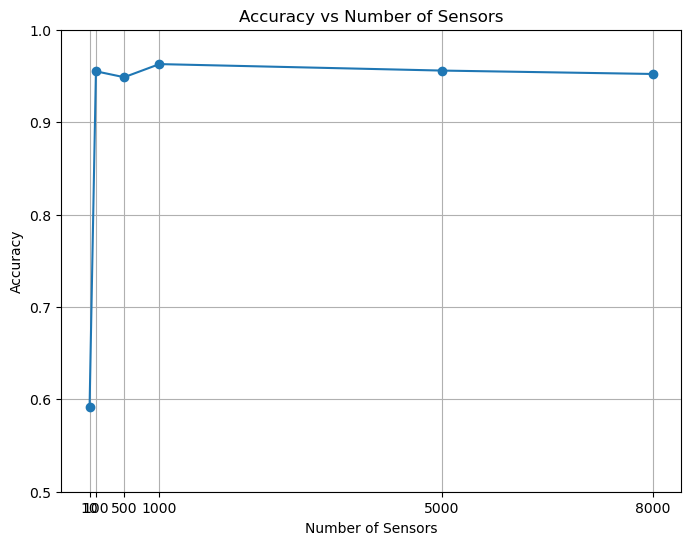

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mse_vs_modes(mse_values, mode_values):
    plt.figure(figsize=(8, 6))
    plt.plot(mode_values, mse_values, marker='o')  # Display markers for each data point
    plt.xlabel('Number of Modes')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Modes')
    plt.xticks(mode_values)
    plt.grid()
    plt.ylim(0.9, 1)  # Set the y-axis limit from 0 to 1 for accuracy
    plt.show()

def plot_mse_vs_sensors(mse_values, sensor_values):
    plt.figure(figsize=(8, 6))
    plt.plot(sensor_values, mse_values, marker='o')  # Display markers for each data point
    plt.xlabel('Number of Sensors')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Sensors')
    plt.xticks(sensor_values)
    plt.grid()
    plt.ylim(0.5, 1)  # Set the y-axis limit from 0 to 1 for accuracy
    plt.show()

# Example usage
mse_values_modes = [0.9772, 0.9759, 0.9784, 0.9751, 0.9548]
mode_values = [1, 2, 3, 4, 5]

mse_values_sensors = [0.5920, 0.9550, 0.9486, 0.9628, 0.9558, 0.9521]
sensor_values = [10, 100, 500, 1000, 5000, 8000]

plot_mse_vs_modes(mse_values_modes, mode_values)
plot_mse_vs_sensors(mse_values_sensors, sensor_values)